In [3]:
# Connect to the Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import sys
sys.path.append("/content/drive/MyDrive/Github/face-comic-recognizer/scr")

In [5]:
import tensorflow as tf
import numpy as np
import os 
import pathlib
import datetime
from constants import IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, SEED
#import data_util
from data_util import *

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

# (0) Data loading

In [ ]:
# Upload kaggle.json
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/Kaggle"
# The dataset will be stored in Google Colab, not in Google Drive!
!pip install --upgrade kaggle
!kaggle datasets download -d defileroff/comic-faces-paired-synthetic-v2
!unzip \*.zip  
%rm *.zip
%rm -rf face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/samples

In [8]:
data_dir = pathlib.Path("/content/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela")
image_count = len(list(data_dir.glob('*/*.jpg')))

# (1) Data extraction

In [9]:
train_ds_paths, val_ds_paths, test_ds_paths = train_val_test_split(
    get_file_paths(folder_path=data_dir), 
    image_count,
    data_dir)

The train set: tf.Tensor(16000, shape=(), dtype=int64)
The validation set: tf.Tensor(2000, shape=(), dtype=int64)
The test set: tf.Tensor(2000, shape=(), dtype=int64)


In [ ]:
print("Train")
get_class_proportions(train_ds_paths.map(lambda x: process_path(x, data_dir, True), num_parallel_calls=AUTOTUNE), 16000)
print("Val")
get_class_proportions(val_ds_paths.map(lambda x: process_path(x, data_dir, True), num_parallel_calls=AUTOTUNE), 2000)
print("Test")
get_class_proportions(test_ds_paths.map(lambda x: process_path(x, data_dir, True), num_parallel_calls=AUTOTUNE), 16000)

In [11]:
# Create the color subsets from |the file paths
# (lambda x: fun(x, my_arg))
train_ds = prepare_for_training(train_ds_paths.map(lambda x: process_path(x, data_dir, True), num_parallel_calls=AUTOTUNE))
val_ds = prepare_for_training(val_ds_paths.map(lambda x: process_path(x, data_dir, True), num_parallel_calls=AUTOTUNE))
test_ds = prepare_for_training(test_ds_paths.map(lambda x: process_path(x, data_dir, True), num_parallel_calls=AUTOTUNE))

In [13]:
# Create the grayscale subsets from the file paths
# (lambda x: fun(x, my_arg))
train_ds_gs = prepare_for_training(train_ds_paths.map(lambda x: process_path(x, data_dir, False), num_parallel_calls=AUTOTUNE))
val_ds_gs = prepare_for_training(val_ds_paths.map(lambda x: process_path(x, data_dir, False), num_parallel_calls=AUTOTUNE))
test_ds_gs = prepare_for_training(test_ds_paths.map(lambda x: process_path(x, data_dir, False), num_parallel_calls=AUTOTUNE))

In [ ]:
show_batch_examples(train_ds, data_dir)

In [ ]:
show_batch_examples(val_ds, data_dir)

# (2) VGG model

## (2.1) VGG block

In [7]:
class VGGBaseBlock(tf.keras.layers.Layer):

    """
    [Conv2D -> BN -> ReLU]
    """
    def __init__(self, 
                 filters, 
                 kernel_size):
        super(VGGBaseBlock, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv2D(self.filters, 
                                           self.kernel_size, 
                                           padding='same')
        self.bn = tf.keras.layers.BatchNormalization()
        
    
    def call(self, input_tensor, training=False):
        x = self.conv(input_tensor)
        x = self.bn(x, training=training)
        x = tf.nn.relu(x)
        return x



In [9]:
class VGGBlock(tf.keras.layers.Layer):
    """
    [VGGBaseBlock*2 -> MaxPool -> Dropout]
    """
    def __init__(self,
                 filters, 
                 kernel_size,
                 pool_size=2, 
                 strides=2,
                 drop_strength=0.2):
        super(VGGBlock, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.drop_strength = drop_strength
        self.conv1 = VGGBaseBlock(self.filters, self.kernel_size)
        self.conv2 = VGGBaseBlock(self.filters, self.kernel_size)
        self.pooling = tf.keras.layers.MaxPool2D(pool_size=pool_size,
                                                  strides=strides,
                                                  padding='same')
        self.drop = tf.keras.layers.Dropout(rate=drop_strength)

    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor, training=training)
        x = self.conv2(x, training=training)
        x = self.pooling(x)
        x = self.drop(x, training=training)
        return x


In [10]:
class VGGModel(tf.keras.Model):
    
    def __init__(self, n_classes=2):
        super(VGGModel, self).__init__()
        self.block_1 = VGGBlock(64, 3)
        self.block_2 = VGGBlock(128, 3)
        self.block_3 = VGGBlock(256, 3)
        self.block_4 = VGGBlock(512, 3)
        self.flatten = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(256, activation='relu')
        self.drop = tf.keras.layers.Dropout(rate=0.2)
        self.classifier = tf.keras.layers.Dense(n_classes-1, activation='sigmoid')
    
    def call(self, input_tensor, training=False):
        x = self.block_1(input_tensor, training)
        x = self.block_2(x, training)
        x = self.block_3(x, training)
        x = self.block_4(x, training)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.drop(x, training=training)
        x = self.classifier(x)
        return x

# (2.2) Training and testing

### (*) Setup

In [47]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [48]:
# Define the checkpoint directory to store the checkpoints.
checkpoint_dir = '/content/drive/MyDrive/Github/face-comic-recognizer/models/checkpoints'
checkpoint_dir_full = os.path.join(checkpoint_dir,  datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
%mkdir {checkpoint_dir_full}
checkpoint_prefix = os.path.join(checkpoint_dir_full, "ckpt_{epoch}")
print(checkpoint_prefix)

/content/drive/MyDrive/Github/face-comic-recognizer/models/checkpoints/20221209-201707/ckpt_{epoch}


In [49]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True)
]

### (**) GPU

In [50]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [12]:
strategy = tf.distribute.MirroredStrategy()

In [13]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


### (2.1.3) Distirubted computing

In [56]:
EPOCHS = 10

In [15]:
with strategy.scope():
  vgg = VGGModel(2)

  vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
            metrics=['accuracy'])

In [58]:
# Train the custom VGG model
history = vgg.fit(train_ds_gs, 
                  validation_data=val_ds_gs,
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  callbacks=callbacks)

Epoch 1/10
500/500 [==============================] - 48s 89ms/step - loss: 0.1675 - accuracy: 0.9864 - val_loss: 7.6335 - val_accuracy: 0.4910
Epoch 2/10
500/500 [==============================] - 43s 87ms/step - loss: 0.0061 - accuracy: 0.9982 - val_loss: 0.0012 - val_accuracy: 0.9995
Epoch 3/10
500/500 [==============================] - 43s 86ms/step - loss: 0.0035 - accuracy: 0.9987 - val_loss: 0.1588 - val_accuracy: 0.9550
Epoch 4/10
500/500 [==============================] - 43s 86ms/step - loss: 0.0149 - accuracy: 0.9964 - val_loss: 3.3118e-05 - val_accuracy: 1.0000
Epoch 5/10
500/500 [==============================] - 43s 86ms/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 0.1178 - val_accuracy: 0.9695
Epoch 6/10
500/500 [==============================] - 43s 86ms/step - loss: 0.0074 - accuracy: 0.9982 - val_loss: 4.7415e-04 - val_accuracy: 1.0000
Epoch 7/10
500/500 [==============================] - 43s 86ms/step - loss: 0.0059 - accuracy: 0.9983 - val_loss: 0.0312 - val_a

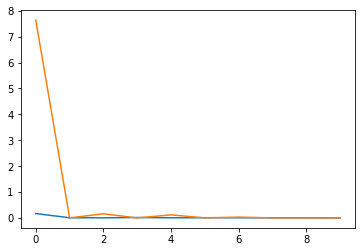

In [60]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss   = history.history['val_loss']
train_acc  = history.history['accuracy']
val_acc    = history.history['val_accuracy']
xc         = range(10)

plt.figure()
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)

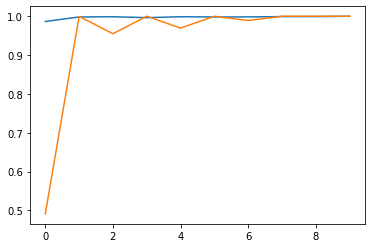

In [61]:
plt.figure()
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)

In [63]:
history

In [64]:
vgg

In [65]:
vgg.evaluate(test_ds_gs)

63/63 [==============================] - 8s 119ms/step - loss: 0.0054 - accuracy: 0.9995


[0.005376400891691446, 0.9994999766349792]